In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots, add_identity
from collections import Counter
from matplotlib.lines import Line2D
from tqdm import tqdm

In [4]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from matplotlib.gridspec import GridSpec
from collections import defaultdict
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut, LeaveOneOut, KFold
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, confusion_matrix
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_absolute_error, median_absolute_error

In [ ]:
from datetime import timedelta

In [ ]:
def load_male_long_df(average_weeks=False, merge_ages=True):
    keep_syllables = np.loadtxt(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt",
        dtype=int,
    )
    df = pd.read_parquet(
        '/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_males_raw_usage_matrix_v00.parquet'
    )

    df = df[keep_syllables]

    if average_weeks:
        rsdf = df.reset_index()
        start_date = rsdf['date'].min()
        end_date = rsdf['date'].max() + timedelta(days=1)

        dt = pd.date_range(start_date, end_date, freq='D')

        date_df = pd.DataFrame(dict(dow=dt.day_of_week), index=dt.date)
        cycle = date_df.diff()['dow'] < 0
        date_df['week'] = cycle.cumsum().rename('week')

        long_df_dates = pd.Series(df.index.get_level_values('date'), index=df.index, name='week')
        df['week'] = long_df_dates.map(lambda x: date_df.loc[x.date(), 'week'])

        if merge_ages:
            df = df.reset_index(level='age')
            df['age'] = df.groupby('week')['week'].transform(lambda x: x + 3)
            df = df.set_index(['age', 'week'], append=True)
        else:
            df = df.set_index('week', append=True)

        new_df = []
        for (mouse, week), _df in df.groupby(['mouse', 'week'], observed=True):
            _df = _df.reset_index(level='age')
            if len(_df) > 2:
                _df = _df.iloc[:2]
            if len(_df) == 1:
                new_df.append(_df.iloc[[0]])
            else:
                _tmp_df = pd.DataFrame(_df.mean()).T
                _tmp_df.index = _df.index[[0]]
                new_df.append(_tmp_df)

        new_df = pd.concat(new_df).set_index('age', append=True)

        return new_df

    return df

In [6]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [7]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

image_ctx = {'image.cmap': 'cubehelix', 'image.interpolation': 'none'}

In [20]:
## arrange data
# keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

df = load_male_long_df(True, True)
# df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_males_raw_usage_matrix_v00.parquet').astype(float)
# df = df[keep_syllables].groupby(['age','uuid','mouse']).mean()
# m_df = df.groupby(['age', 'mouse']).mean()
# m_df = m_df.query('age<90')
m_df = df.query('age<90')

In [71]:
# choose a model for decoder
clf = PLSRegression(n_components=8)
cv = LeaveOneOut()
#number of iterations for shuffle
it=1

In [72]:
format_plots()

In [73]:
#prepare data
data=m_df.copy()
y_age =data.index.get_level_values('age').to_numpy()
X=data.to_numpy()

In [78]:
#decoder
y_pred = cross_val_predict(clf, X, y_age, cv=cv)
r2_age = r2_score(y_age, y_pred)
print(r2_age)

0.7862152610950195


In [79]:
res_age = y_age.flatten()-y_pred.flatten()
res_less = res_age[res_age<0]
res_more = res_age[res_age>0]
print(np.mean(abs(res_less)))
print(np.mean(abs(res_more)))

6.967743512751708
8.287484900784328


In [80]:
# Calculating Mean Absolute Error (MAE)
mae_age = median_absolute_error(y_age, y_pred)
print("Median Absolute Error (MAE):", mae_age)

Median Absolute Error (MAE): 6.077521162789168


In [70]:
df_res = pd.DataFrame(res_age)
df_res['age'] = y_age.flatten()
df_res.to_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/longv1_residuals_male.parquet')

/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/pandas/io/parquet.py:190: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


In [13]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr
print(pearsonr(y_age, y_pred.flatten()))
print(spearmanr(y_age, y_pred.flatten()))

PearsonRResult(statistic=0.9086771938067453, pvalue=0.0)
SignificanceResult(statistic=0.8831264285587023, pvalue=9.171097778388275e-297)


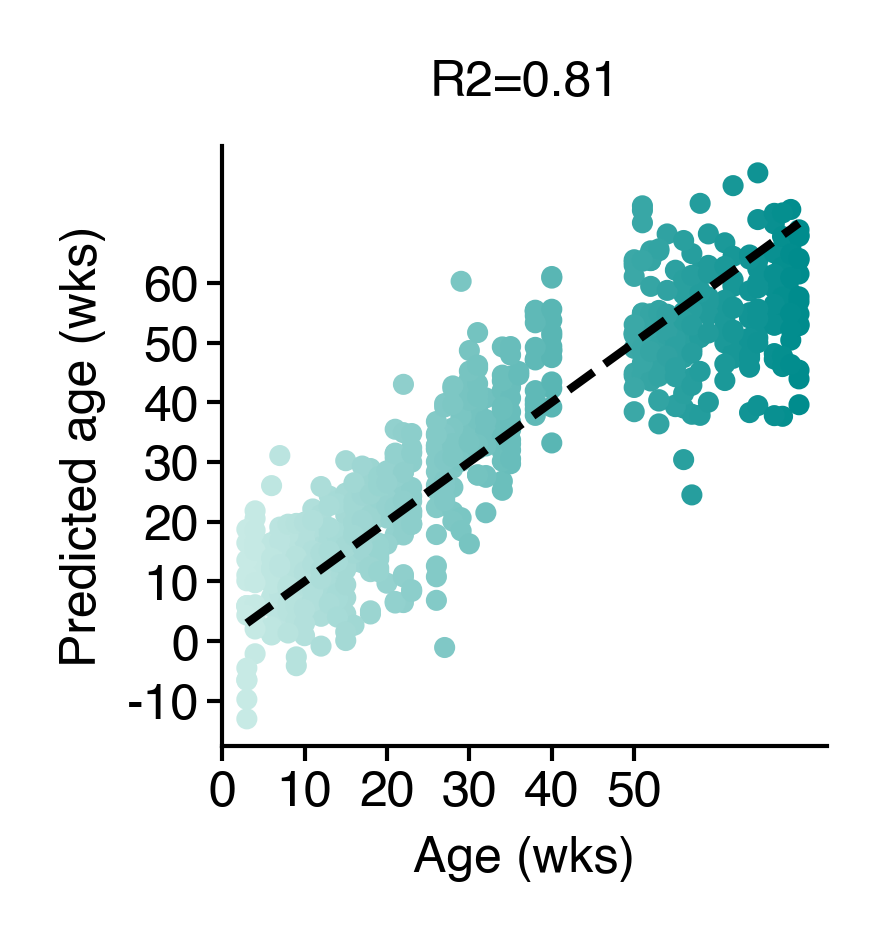

In [77]:
fig = figure(1.3, 1.3)
ax = fig.gca()
plt.scatter(y_age, y_pred, c=y_age, cmap=cmm, s=3)
#add_identity(ax, ls='--', color='k', zorder=-1)
ax.set(xlim=(0, None),yticks=[-10,0, 10, 20, 30, 40,50,60], xticks=[0, 10, 20, 30, 40,50], xlabel="Age (wks)", ylabel="Predicted age (wks)", 
       title=f"R2={r2_age:0.2f}",
      )
plt.plot(y_age, y_age, linestyle='--', color='black')
sns.despine()

In [15]:
c = PlotConfig()
#fig.savefig(c.dana_save_path / "fig3"/ 'age_regression_longv2_male.pdf', bbox_inches='tight')

In [16]:
#shuffle
ysh_score_age=[]
ysh_age=[]
ysh_predict_age=[]
ysh_mse_age=[]
for i in tqdm(range(it)):
    ysh_temp=np.random.permutation(y_age)
    y_pred_temp = cross_val_predict(clf, X, ysh_temp, cv=cv, n_jobs=-1)
    ysh_score_age.append(r2_score(y_age, y_pred_temp))
    ysh_age.extend(ysh_temp)
    ysh_predict_age.extend(y_pred_temp)
    #ysh_mse_age.append(mean_squared_error(y_age, y_pred_temp))

100%|████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.62s/it]


/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


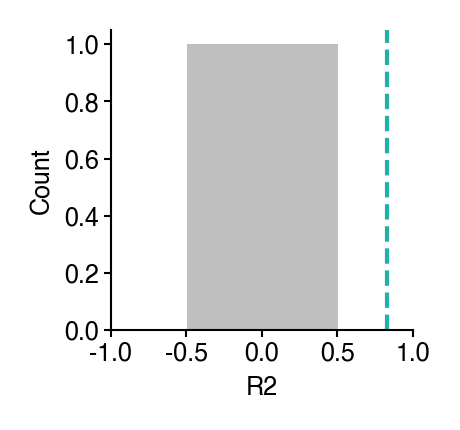

In [17]:
fig = plt.figure(figsize=(1.3, 1.3))
fig.dpi = 300
ax = sns.histplot(data=ysh_score_age, fill=True, element='step', lw=0, color='black', alpha=0.25)
ax.axvline(r2_age, color='#20B2AA', lw=1, linestyle='--')

ax.set(ylabel='Count')
ax.set(xlabel='R2')
plt.xlim([-1,1])
sns.despine()
c = PlotConfig()
#fig.savefig(c.dana_save_path / "fig3"/ 'age_regression_shuf_longv2_male.pdf', bbox_inches='tight')

In [18]:
## leave one age out

In [19]:
# Prepare data
data = m_df.copy()

# Extract features and target
X = data.to_numpy()
y = data.index.get_level_values('age').to_numpy()
groups = data.index.get_level_values('age').to_numpy()

cv = LeaveOneGroupOut()
cv.get_n_splits(X, y, groups)

# decoder
y_age=y
y_pred = cross_val_predict(clf, X, y_age, groups=groups, cv=cv, n_jobs=-1)
r2_age = r2_score(y_age, y_pred)

In [20]:
r2_age = r2_score(y_age, y_pred)
print(r2_age)

0.8203830426942939


In [21]:
from scipy.stats import pearsonr
print(pearsonr(y_age, np.array(y_pred).flatten()))

PearsonRResult(statistic=0.9057775376636733, pvalue=0.0)


In [22]:
# Calculating Mean Absolute Error (MAE)
mae_age = median_absolute_error(y_age, y_pred)
print("Median Absolute Error (MAE):", mae_age)

Median Absolute Error (MAE): 6.0688133172945555


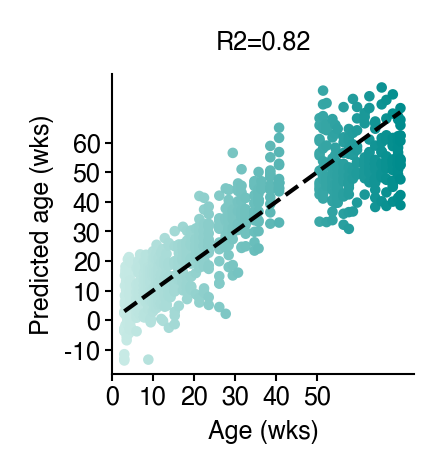

In [23]:
fig = figure(1.3, 1.3)
ax = fig.gca()
plt.scatter(y_age, y_pred, c=y_age, cmap=cmm, s=3)
#add_identity(ax, ls='--', color='k', zorder=-1)
ax.set(xlim=(0, None),yticks=[-10,0, 10, 20, 30, 40,50,60], xticks=[0, 10, 20, 30, 40,50], xlabel="Age (wks)", ylabel="Predicted age (wks)", 
       title=f"R2={r2_age:0.2f}",
      )
plt.plot(y_age, y_age, linestyle='--', color='black')
sns.despine()

In [24]:
c = PlotConfig()
#fig.savefig(c.dana_save_path / "fig3"/ 'age_regression_leave_age_out_longv2_male.pdf', bbox_inches='tight')

In [25]:
## shuffle
#shuffle
ysh_score_age=[]
ysh_age=[]
ysh_predict_age=[]
ysh_mse_age=[]
for i in tqdm(range(it)):
    ysh_temp=np.random.permutation(y_age)
    y_pred_temp = cross_val_predict(clf, X, ysh_temp, groups=groups, cv=cv, n_jobs=-1)
    ysh_score_age.append(r2_score(y_age, y_pred_temp))
    ysh_age.extend(ysh_temp)
    ysh_predict_age.extend(y_pred_temp)
    ysh_mse_age.append(mean_squared_error(y_age, y_pred_temp))

100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.24it/s]


/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


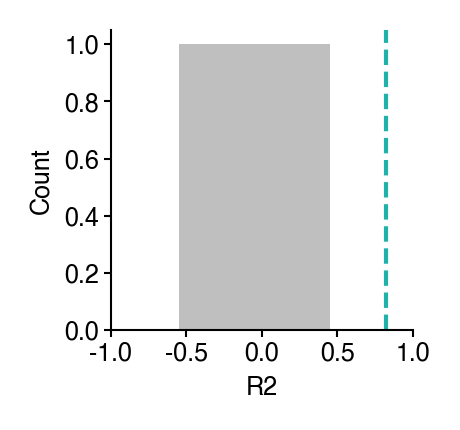

In [26]:
fig = plt.figure(figsize=(1.3, 1.3))
fig.dpi = 300
ax = sns.histplot(data=ysh_score_age, fill=True, element='step', lw=0, color='black', alpha=0.25)
ax.axvline(r2_age, color='#20B2AA', lw=1, linestyle='--')

ax.set(ylabel='Count')
ax.set(xlabel='R2')
plt.xlim([-1,1])
sns.despine()
c = PlotConfig()
#fig.savefig(c.dana_save_path / "fig3"/ 'age_regression_shuf_longv2_male_age_out.pdf', bbox_inches='tight')